# Securing Sensitive Data: AI Methods for Detecting Personally Identifiable Information 

### Structure of this notebook

The notebook consists of five sections [Initialization](#0), [Data](#1), [Exploratory Data Analysis](#2), [Modelling](#3), [Results and Analysis](#4), and  [Functions](#5). 

- **Initialization**: In this initial section, we define the necessary packages and establish the color theme used throughout the notebook.

- **Data**: This section contains information about the dataset and its collection process, followed by a detailed explanation of data cleaning procedures.

- **Exploratory Data Analysis**: Here, we delve deeper into the dataset by ...

- **Modelling**: In this section, we develop the models......

- **Results and Analysis**: ....

- **Functions**: All the plot functions utilized in the analysis are included in the end of this Notebook.


### Table of Contents
0. [Initialization](#0)
1. [Data](#1)
2. [Exploratory Data Analysis](#2)
3. [Modelling](#3)
4. [Results and Analysis](#4)
5. [Functions](#5)

__________

<a id="0"></a>
## Section 0: Initialization

In [162]:
# Standard libraries
import json
import itertools
import re
import string
from collections import Counter
from itertools import chain
import math

# Data manipulation
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import ast

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import HTML

# NLP
import spacy
from spacy import displacy
from spacy.tokens import Doc, Span
from spacy.lang.en import English
spacy_nlp = spacy.load('en_core_web_sm')
eng_tokenizer = English().tokenizer

# Text Processing and Analysis
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, ImageColorGenerator
import random
from nltk.corpus import PlaintextCorpusReader
import nltk
import string
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Import custom functions
from Functions.Spacy_Tokenizer import adjust_token_labels, refine_punctuation_labels, create_bio_labels
from Functions.Ner_Visualizer import *
from Functions.tdidf_wordclouds import *

# Ignore warnings
pd.options.mode.chained_assignment = None

__________

<a id="1"></a>
## Section 1: Data

This project uses data from a Kaggle Competition named *The Learning Agency Lab - PII Data Detection*. The train dataset comprises around 6,807 essays written by students from an online course. All the essays was a response to a single assignment, asking the student to apply course material to a real-world problem. The goal of this project is to annotate personally identifiable information (PII) in each essay. To keep the students' privacy safe, any real PII has been replaced by surrogate identifiers through a semi-automated method.

The goal of this project is to identify the following types of PII:

- **Student Names:** The name of a student. This excludes instructors, authors, and other person names.
- **Student Emails:** A student's email address. 
- **Student Username:** A student's username. 
- **Student ID Number:** A student's ID number or social security number. 
- **Student Phone Number:** A phone number associated with a student.
- **Personal URL:** A URL that might be used to identify a student.
- **Student Address:** A street address that is related to the student. 

The data is formatted in JSON, detailing each essay's identifier, its full text, a list of tokens, information about whitespace, and annotations for each token. The tokens were created using the SpaCy English tokenizer. 

Token labels are presented in BIO (Beginning, Inner, Outer) format:
- *B-* prefix means the beginning of a PII entity.
- *I-* indicates a continuation of a PII entity.
- *O* is used for tokens unrelated to PII.

The data includes:
- **index (int):** An index number for each essay.
- **document id (int):** A unique integer ID for each essay.
- **full_text (string):** The full text of the essay in UTF-8.
- **tokens (list):** A list of tokens, each a string.
- **trailing_whitespace (list):** A list indicating if each token is followed by a space.
- **labels (list):** Labels for each token (only in the training data), showing the PII type in BIO format.

Since this dataset contained only 6,807 essays, which primarily included the *B-NAME_STUDENT*, class, we needed to find more data with a more diverse distribution of the different classes. We then found additional data generated by a Large Language Model (LLM), also on Kaggle. It contains 4,434 texts along with their corresponding annotated labels in the same way as the original train data. Thus, we will use both datasets for this project.

## 1.1 Data Loading

### 1.1.1 Load original data

In [2]:
# Load original train data in dictionary and dataframe format
with open('data/train.json', 'r') as f:
    original_data = json.load(f)

original_data_df = pd.read_json('data/train.json')

print('Number of documents:',len(original_data_df))

Number of documents: 6807


In [3]:
original_data_df.head(2)

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."


### 1.1.2 Load LLM generated data

In [4]:
# Load LLM generated data in dataframe format
llm_data_df = pd.read_csv('data/pii_dataset.csv')
print('Number of documents:',len(llm_data_df))

Number of documents: 4434


In [5]:
llm_data_df.head(2)

,document,text,tokens,trailing_whitespace,labels,prompt,prompt_id,name,email,phone,job,address,username,url,hobby,len
0,1073d46f-2241-459b-ab01-851be8d26436,"My name is Aaliyah Popova, and I am a jeweler ...","['My', 'name', 'is', 'Aaliyah', 'Popova,', 'an...","[True, True, True, True, True, True, True, Tru...","['O', 'O', 'O', 'B-NAME_STUDENT', 'I-NAME_STUD...",\n Aaliyah Popova is a jeweler with 13 year...,1,Aaliyah Popova,aaliyah.popova4783@aol.edu,(95) 94215-7906,jeweler,97 Lincoln Street,NaN,NaN,Podcasting,363
1,5ec717a9-17ee-48cd-9d76-30ae256c9354,"My name is Konstantin Becker, and I'm a develo...","['My', 'name', 'is', 'Konstantin', 'Becker,', ...","[True, True, True, True, True, True, True, Tru...","['O', 'O', 'O', 'B-NAME_STUDENT', 'I-NAME_STUD...",\n Konstantin Becker is a developer with 2 ...,1,Konstantin Becker,konstantin.becker@gmail.com,0475 4429797,developer,826 Webster Street,NaN,NaN,Quilting,255


## 1.2 Preprocessing

In [6]:
original_data_df = original_data_df.rename(columns={'full_text':'text'}) # Rename column to 'text'
original_data_df['llm_generated'] = False # Add column to indicate if the text was generated by LLM
original_data_df['prompt_id'] = -1  # Add column to indicate the prompt id

In [7]:
llm_data_df['llm_generated'] = True # Add column to indicate if the text was generated by LLM

llm_data_df[["tokens", "trailing_whitespace", "labels"]] = llm_data_df[["tokens", "trailing_whitespace", "labels"]].map(ast.literal_eval) # Convert string to list
llm_data_df["document"] = llm_data_df["document"].astype("category").cat.codes + (original_data_df.document.max() + 1) # make sure document id is unique and changing to int

**Addressing the Punctuation Issue in the LLM generated data set**:

In the context of text processing, particularly when handling datasets for named entity recognition (NER), punctuation plays a crucial role in determining the boundaries and labels of tokens. The standard tokenization by tools like SpaCy might segment a phrase such as "Aaliyah, by" into ["Aaliyah", ",", "by"] with trailing spaces marked as [False, True, True], and labels ["B-NAME-STUDENT", "O", "O"]. This segmentation accurately reflects the presence of punctuation as separate from named entities, even when there's no space between them.

However, the LLM dataset presents a unique challenge. It tokenizes text differently, often merging punctuation with adjacent tokens due to the presence of spaces around all characters. For instance, it would tokenize "Aaliyah, by" as ["Aaliyah,", "by"] with trailing spaces [True, True], assigning labels ["B-NAME-STUDENT", "O"]. This approach results in punctuation being considered part of a preceding token, thus receiving a single, unified label. Consequently, when aligning the LLM dataset's tokenization with the original, we encounter difference.

This inconsistency arises from the LLM dataset treating punctuation without spaces as part of adjacent tokens, potentially conflicting with the original dataset's labeling scheme. To resolve this, adjustments are necessary to ensure that the dataset aligns more closely with standard tokenization and labeling practices. This involves re-evaluating tokens and labels to correctly identify and separate punctuation from named entities, thereby avoiding the mislabeling that can confuse NER models. By addressing this issue, we aim to improve the dataset's utility for training more accurate and reliable NER systems.

In [8]:
llm_data_df_tokenized = llm_data_df.apply(adjust_token_labels, axis=1)
llm_data_df_tokenized["labels"] = llm_data_df_tokenized.apply(refine_punctuation_labels, axis=1).apply(create_bio_labels)
llm_data_df_tokenized['text'] = llm_data_df['tokens'].apply(lambda x: ' '.join(x))
llm_data_df_tokenized[['prompt_id', 'llm_generated']] = llm_data_df[['prompt_id', 'llm_generated']]

In [9]:
llm_data_df_tokenized.head(2)

,document,tokens,trailing_whitespace,labels,text,prompt_id,llm_generated
0,22968,"[My, name, is, Aaliyah, Popova, ,, and, I, am,...","[True, True, True, True, False, True, True, Tr...","[O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O...","My name is Aaliyah Popova, and I am a jeweler ...",1,True
1,24398,"[My, name, is, Konstantin, Becker, ,, and, I, ...","[True, True, True, True, False, True, True, Fa...","[O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O...","My name is Konstantin Becker, and I'm a develo...",1,True


### 1.2.1 Combine data sets

In [10]:
data_df = pd.concat([original_data_df, llm_data_df_tokenized], ignore_index=True)

### 1.2.2 Encode target

In [11]:
def encode_labels(df):
    df = df.copy()
    df["unique_labels"] = df["labels"].apply(lambda x: set(
        [l.split('-')[1] if l != 'O' else l for l in x]
         ))

    mlb = MultiLabelBinarizer()
    one_hot_encoded = mlb.fit_transform(df['unique_labels'])
    one_hot_df = pd.DataFrame(one_hot_encoded, columns=mlb.classes_)
    df = pd.concat([df, one_hot_df], axis=1)
    
    # add 'OTHER' column which is only true when we have no other label in text
    df['OTHER'] = df['unique_labels'].apply(lambda x: 1 if len(x - {"O"}) == 0 else 0)
    
    return df, list(mlb.classes_) + ['OTHER']

In [12]:
df, label_classes = encode_labels(data_df)

In [13]:
df.head(2)

,document,text,tokens,trailing_whitespace,labels,llm_generated,prompt_id,unique_labels,EMAIL,ID_NUM,NAME_STUDENT,O,PHONE_NUM,STREET_ADDRESS,URL_PERSONAL,USERNAME,OTHER
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-...",False,-1,"{O, NAME_STUDENT}",0,0,1,1,0,0,0,0,0
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O...",False,-1,"{O, NAME_STUDENT}",0,0,1,1,0,0,0,0,0


__________

<a id="2"></a>
## Section 2: Exploratory Data Analysis

## 2.1 Data Visualization

### 2.1.1 Target Distrbution

First, we are examining the frequency of each target in all the documents excluding target "O".

In [ ]:
labels = df['labels'].tolist()
# Flatten the list of lists
flattened_labels = list(itertools.chain.from_iterable(labels))
# Count the occurrences of each label
label_counts = Counter(flattened_labels)
# Separate the labels and their counts for plotting
labels, counts = zip(*label_counts.items())

# Create the bar plot
fig = go.Figure([go.Bar(x=labels[1:], y=counts[1:])])
fig.update_layout(title_text='Frequency of each label', xaxis_title='Labels', yaxis_title='Frequency')
fig.show()

- It is evident that the most common targets are *B-NAME-STUDENT*, *I-NAME-STUDENT*, *B-STREET_ADDRESS*, and *I-STREET_ADDRESS*. It is not surprising that *NAME-STUDENT* is the most frequently occurring target.
- It is also observed that some targets are very rare, such as *B-ID_NUM*, *I-URL_PERSONAL*, and *I-ID_NUM*.
- We notice the absence of certain potential targets like *I-EMAIL* and *I-USERNAME*. However, these targets are less common since emails or usernames extending beyond a single word are atypical.
- Overall, we have a diverse array of targets, which is crucial for effective model training.

In the following, we are examining the distribution of unqiue variables in each document.

In [36]:
df['unique_labels'] = df['labels'].apply(lambda x: list(set(x)))
df['num_unique_labels'] = df['unique_labels'].apply(len)

# Histogram of number of unique labels per document
fig = px.histogram(df, x='num_unique_labels', nbins=20, 
                   labels={'num_unique_labels': 'Number of unique labels'},
                   title='Histogram of number of unique labels per document')
fig.update_layout(yaxis_title='Frequency') 
fig.show()


- It is seen that it is most common for each document to have at least one unique target. 
- It is also noticed that for some reason some texts do also have up to 6 or 8 unique labels. 

It is also interesting to see how many targets there are in each document when excluding label "O".

In [ ]:
df['num_labels'] = df['labels'].apply(lambda labels: len([label for label in labels if label != "O"]))
filtered_df = df[df['num_labels'] > 0]
# Histogram of number of unique labels per document
fig = px.histogram(filtered_df, x='num_labels', nbins=50, 
                   labels={'num_labels': 'Number of labels'},
                   title='Histogram of number of labels per document')
fig.update_layout(yaxis_title='Frequency') 
fig.show()

In [ ]:
print("Number of documents without any target:", len(df['num_labels']==0))

- It is seen that we are around 11241 documents without any targets. 
- Also, we have some few documents with many targets. 
- Otherwise we see that most of the documents have around 5-15 targets.

### 2.1.2 Document distribution

First, we are visualizing the length of the text of both the documents with and without labels

In [ ]:
df_with_labels = df[df['labels'].apply(lambda x: len(set(x)) > 1)] #with labels
df_non_labels = df[df['labels'].apply(lambda x: 'O' in x and len(set(x)) == 1)] #without labels 

df_with_labels['Documents'] = 'With Labels'
df_non_labels['Documents'] = 'Without Labels'
df['Documents'] = "All Documents"

# Calculate text length
df['len_text'] = df['text'].apply(len)
df_with_labels['len_text'] = df_with_labels['text'].apply(len)
df_non_labels['len_text'] = df_non_labels['text'].apply(len)

# Combine the dataframes
combined_df = pd.concat([df_with_labels, df_non_labels, df])

# Plotting
fig = px.histogram(combined_df, x='len_text', color='Documents', labels={'len_text': 'Length of text'},
                   nbins=500, title='Histogram of Length of Text per Document')

# Show the plot
fig.show()

- It is clear that the distribution of text length is approximating a heavy tailed normal distribution for all three.

- Let us see the length of tokens

In [ ]:
combined_df['Length of tokens'] = combined_df['tokens'].apply(len)
# Plotting
fig = px.histogram(combined_df, x='Length of tokens', color='Documents',
                   nbins=500, title='Histogram of Length of Tokens per Document')
fig.show()

- It is seen that all three distrbutions are quiet similar. 

### 2.1.3 POS Labels

In the following, we will calculates normalized positions for each label in the data. 

In [ ]:
df["Labels Pos"] = df["labels"].apply(lambda labels: np.arange(1, len(labels) + 1) / len(labels))
exp_df = df.explode(["tokens", "labels", "Labels Pos"])
exp_df["labels"] = pd.Categorical(exp_df["labels"], categories=labels, ordered=True)
exp_df = exp_df.sort_values(by="labels", ascending=False)
label_tokens = exp_df.groupby("labels", observed=False).agg(list)
label_tokens["counts"] = label_tokens["tokens"].apply(len)

In [ ]:
fig = px.scatter(exp_df, x='Labels Pos', y='labels', title='Scatter Plot of Labels in Documents',)
fig.show()

## 2.2 Named Entity Recognition (NER) using spaCy 

In the following, we will visualize text data with their corresponding labels using NER spaCy library.

- First, we are presenting a text that contains the highest number of unique labels, which, in our dataset, reached a maximum of eight.

In [44]:
visualize_ner(df.sort_values(by=["num_unique_labels"], ascending=False).reset_index(drop=True).iloc[0:1])

In [48]:
df.sort_values(by=["num_unique_labels"], ascending=False)['unique_labels'].iloc[0]

['B-EMAIL',
 'I-PHONE_NUM',
 'B-PHONE_NUM',
 'I-STREET_ADDRESS',
 'O',
 'B-STREET_ADDRESS',
 'I-NAME_STUDENT',
 'B-NAME_STUDENT']

- The illustration demonstrates the accurate labeling of the text. Additionally, it highlights the use of labels that indicate both the beginning of the target entity and its continuation

- In the example below, we showcase text featuring multiple labels. Notably, the sequence includes an email address after the PHONE_NUM class ,which are not labeled.

In [33]:
visualize_ner(df[df['document'] == 9854])

- The interesting aspect is determining whether the unlabeled email is a personal email or an oversight in labeling. Given the semi-automated nature of the labeling process, we anticipate encountering several such errors in the data.

- Lastly, we are showing one of the texts with most labels

In [32]:
visualize_ner(df.sort_values(by=["num_labels"], ascending=False).reset_index(drop=True).iloc[1:2])

## 2.3 WordClouds using tf–idf

- First, we will investigate the wordclouds using all documents

In [160]:
documents = preprocess_texts(df)

In [161]:
tokenize_documents = [doc.lower().split() for doc in documents]
tfidf_documents = calc_td_idf(tokenize_documents)

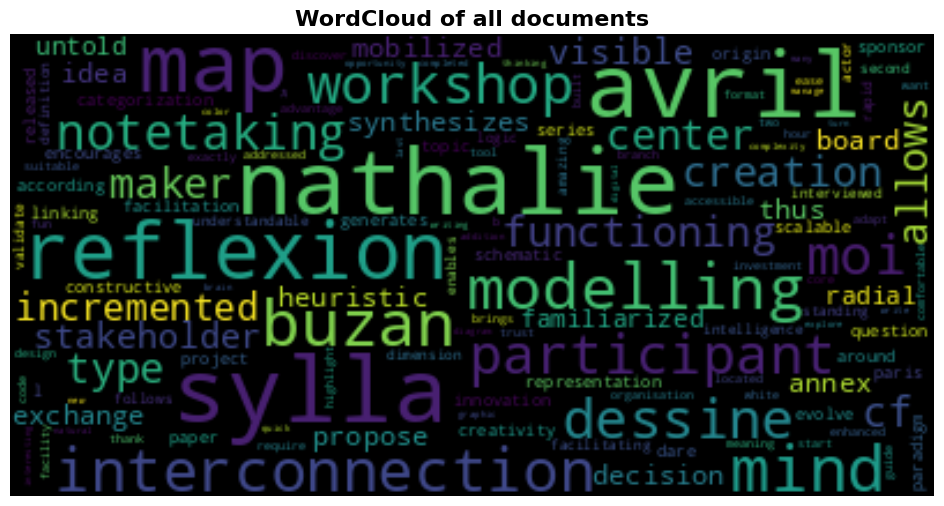

In [163]:
plot_wordcloud("WordCloud of all documents", tfidf_documents[0])

- Wordcloud of target Student Name

In [168]:
extracted_tokens_per_document = []

for _, row in df.iterrows():
    document_tokens = [token for token, label in zip(row['tokens'], row['labels']) if label in ['B-NAME_STUDENT', 'I-NAME_STUDENT']]
    extracted_tokens_per_document.append(document_tokens)

In [194]:
tokenize_names = [[word.lower() for word in sublist] for sublist in extracted_tokens_per_document]
tfidf_names = calc_td_idf(tokenize_names)
tfidf_names = {k: v for d in tfidf_names for k, v in d.items()}

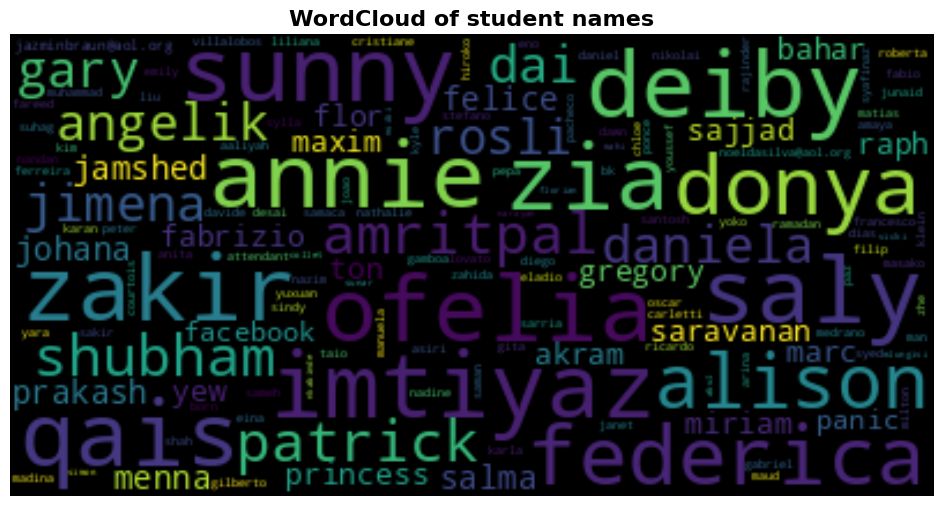

In [196]:
plot_wordcloud("WordCloud of student names", tfidf_names)

In [201]:
def extract_tokens_before_labels(data_df, target_label, num_tokens=2):
    all_tokens_before_label = []
    
    for _, row in data_df.iterrows():
        tokens, labels = row['tokens'], row['labels']
        tokens_before_label = [
            tokens[i-num_tokens:i] 
            for i, label in enumerate(labels) 
            if label == target_label and i-num_tokens >= 0
        ]
        all_tokens_before_label.extend(tokens_before_label)
    
    return all_tokens_before_label

# Extracting the two tokens before 'B-NAME_STUDENT'
tokens_before_B_NAME_STUDENT = extract_tokens_before_labels(df, 'B-NAME_STUDENT')



In [203]:
tokens_before_B_NAME_STUDENT = [[word.lower() for word in sublist] for sublist in tokens_before_B_NAME_STUDENT]
tfidf_before_names = calc_td_idf(tokens_before_B_NAME_STUDENT)
tfidf_before_names = {k: v for d in tfidf_before_names for k, v in d.items()}

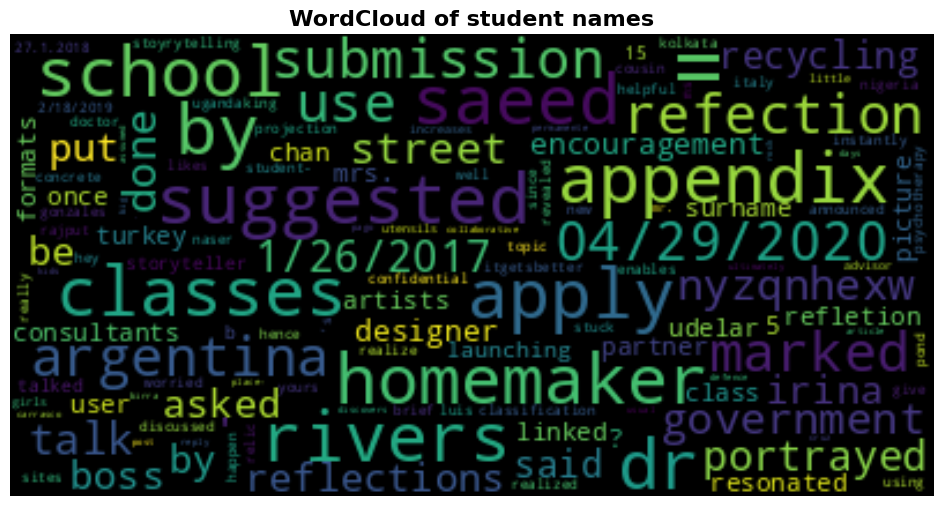

In [204]:
plot_wordcloud("WordCloud of student names", tfidf_before_names)

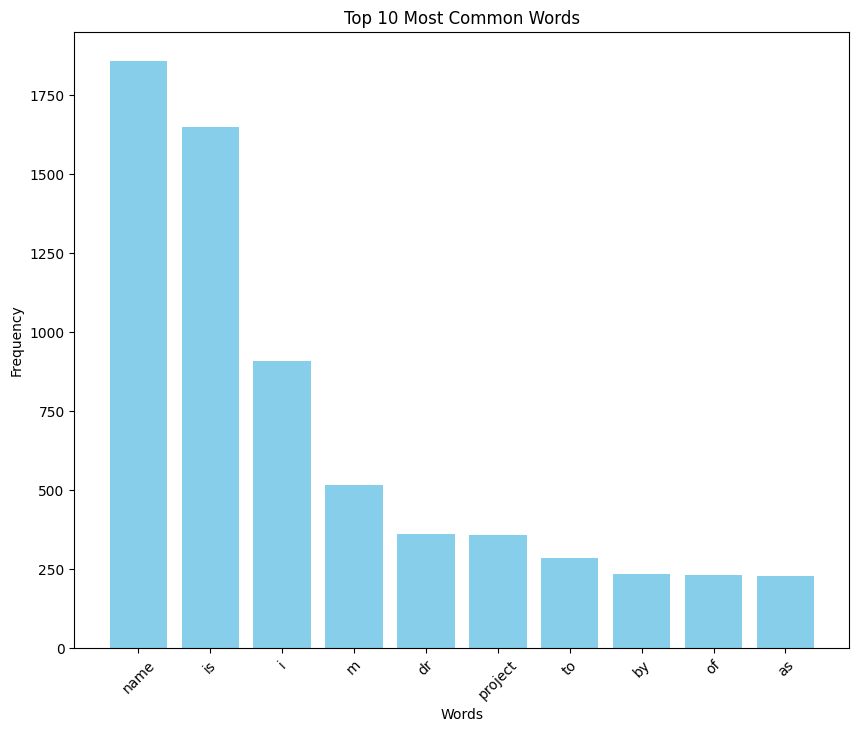

In [209]:
import re
from itertools import chain

# Assuming 'extracted_tokens_per_document' is your list of lists of tokens
cleaned_tokens_per_document = [
    [re.sub(r'[^\w\s]', '', token) for token in sublist]
    for sublist in tokens_before_B_NAME_STUDENT
]

# Optionally, you might want to remove empty tokens that result from this cleaning
cleaned_tokens_per_document = [
    [token for token in sublist if token.strip()]
    for sublist in cleaned_tokens_per_document
]


all_tokens = [token for sublist in cleaned_tokens_per_document for token in sublist]

# Count the frequencies of each word
word_counts = Counter(all_tokens)

import matplotlib.pyplot as plt

# Get the most common words and their counts
num_most_common_words = 10  # Change this to plot more or fewer words
most_common_words = word_counts.most_common(num_most_common_words)
words, frequencies = zip(*most_common_words)  # This unpacks the list of tuples into two tuples

# Plotting
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
plt.bar(words, frequencies, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate the x-axis labels to make them readable
plt.title('Top {} Most Common Words'.format(num_most_common_words))
plt.show()
